# Cheminformatics
ownership of the code goes to Willem Jespers: https://github.com/jesperswillem/CBR_teaching#cbr_teaching.
The original code was adapted for this specific project.

## This lab is in part adapted from TeachOpenCADD
(https://noteable-beta.edina.ac.uk/user/wmk69tm57bfauozjthxzn1/tree/teachopencadd.git/teachopencadd/talktorials)

In [32]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

filterwarnings("ignore")
SEED = 22

In [33]:
import os
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
try:
    os.mkdir('Cheminformatics')
except:
    print("Directory already exists")
os.chdir('Cheminformatics')

Directory already exists


In [34]:
CHEMBLID = 'CHEMBL217'
FILENAME = 'CHEMBL217'

data = pd.read_csv(FILENAME, sep='\t')
print("There are a total of {} datapoints in this set".format(len(data)))
data.head()


There are a total of 22045 datapoints in this set


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL228278,NaN,None,514.69,1,4.71,trans-14,COc1ccc(S(=O)(=O)N[C@H]2CC[C@H](N3CCC(c4ccccc4...,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1137555,1,Scientific Literature,Bioorg Med Chem Lett,2007.0,None,NaN,NaN
1,CHEMBL390129,NaN,None,516.70,1,4.96,cis-13,COc1ccc(S(=O)(=O)N[C@H]2CC[C@@H](N3CCC(c4ccccc...,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1137555,1,Scientific Literature,Bioorg Med Chem Lett,2007.0,None,NaN,NaN
2,CHEMBL256597,NaN,None,505.49,2,6.04,trans-16,CC(C)Oc1ccccc1N1CCN(C2CCC(NC(=O)Nc3c(Cl)cccc3C...,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1143857,1,Scientific Literature,Bioorg Med Chem Lett,2008.0,None,NaN,NaN
3,CHEMBL209832,NaN,None,320.40,0,1.98,3i,c1ccc(-n2cc(CN3CCN(c4ncccn4)CC3)cn2)cc1,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1147793,1,Scientific Literature,Bioorg Med Chem Lett,2006.0,CHEMBL3308072,NaN,NaN
4,CHEMBL256475,NaN,None,438.56,0,3.81,19,Cc1ncoc1-c1nnc(SCCCN2CCc3cc4onc(C)c4cc3CC2)n1C,Ki,'>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1142271,1,Scientific Literature,Bioorg Med Chem Lett,2008.0,None,NaN,NaN


In [4]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data.head()

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL228278,6.88,COc1ccc(S(=O)(=O)N[C@H]2CC[C@H](N3CCC(c4ccccc4...,B,'=',133.00
1,CHEMBL390129,6.78,COc1ccc(S(=O)(=O)N[C@H]2CC[C@@H](N3CCC(c4ccccc...,B,'=',165.00
2,CHEMBL256597,8.33,CC(C)Oc1ccccc1N1CCN(C2CCC(NC(=O)Nc3c(Cl)cccc3C...,B,'=',4.70
3,CHEMBL209832,5.22,c1ccc(-n2cc(CN3CCN(c4ncccn4)CC3)cn2)cc1,B,'=',6000.00
4,CHEMBL256475,NaN,Cc1ncoc1-c1nnc(SCCCN2CCc3cc4onc(C)c4cc3CC2)n1C,F,'>',1258.93


In [5]:
import numpy as np
pd_data["active"] = np.zeros(len(pd_data))

pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 7671
Number of inactive compounds: 14374


In [6]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 16725 activity points left


In [7]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [8]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [9]:
compound_df = pd_data.copy()

In [10]:
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL228278,6.88,COc1ccc(S(=O)(=O)N[C@H]2CC[C@H](N3CCC(c4ccccc4...,B,'=',133.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL390129,6.78,COc1ccc(S(=O)(=O)N[C@H]2CC[C@@H](N3CCC(c4ccccc...,B,'=',165.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL256597,8.33,CC(C)Oc1ccccc1N1CCN(C2CCC(NC(=O)Nc3c(Cl)cccc3C...,B,'=',4.7,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    for model in models:
        ml_model = model["model"]
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        test_pred = ml_model.predict(test_x)
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        auc = roc_auc_score(test_y, test_prob)
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [12]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    test_prob = ml_model.predict_proba(test_x)[:, 1]

    test_pred = ml_model.predict(test_x)

    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [13]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    ml_model.fit(train_x, train_y)

    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [14]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 13316
Test data size: 3330


In [15]:
param = {
    "n_estimators": 100,
    "criterion": "entropy",
}
model_RF = RandomForestClassifier(**param)

In [16]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.69
Specificity: 0.86
AUC: 0.87


Directory already exists, continuing


'/home/jovyan/Cheminformatics/results/roc_auc.png'

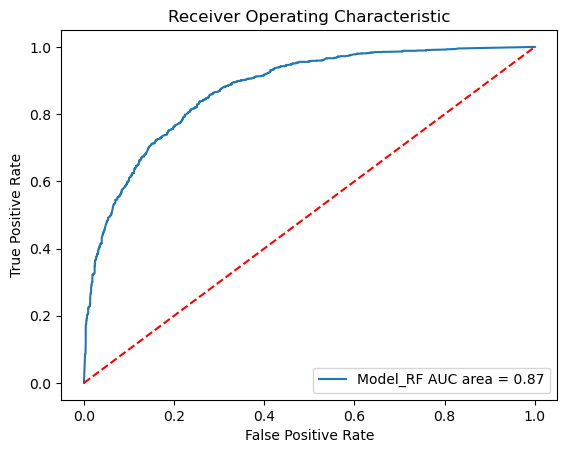

In [17]:
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

In [18]:
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.69
Specificity: 0.86
AUC: 0.85


'/home/jovyan/Cheminformatics/results/roc_auc.png'

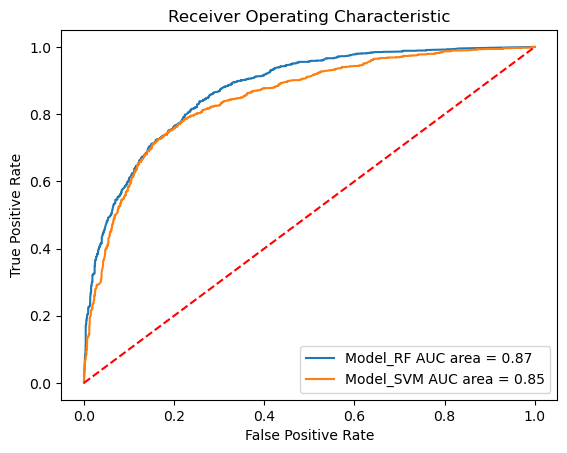

In [19]:
models.append({"label": "Model_SVM", "model": model_SVM})

plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

In [20]:
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.64
Specificity: 0.79
AUC: 0.81


'/home/jovyan/Cheminformatics/results/roc_auc.png'

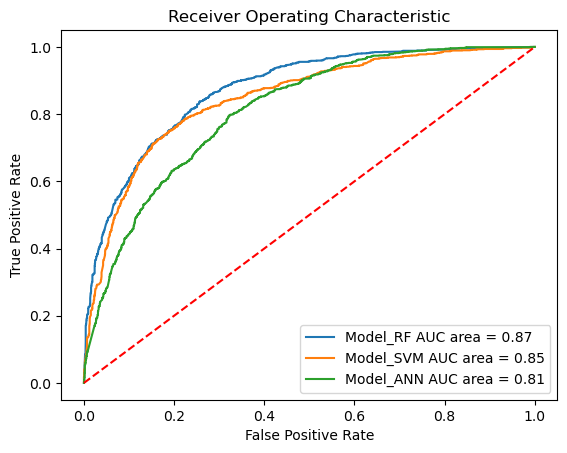

In [21]:
models.append({"label": "Model_ANN", "model": model_ANN})
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

In [22]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    for train_index, test_index in kf.split(df):
        fold_model = clone(ml_model)

        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        fold_model.fit(train_x, train_y)

        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [23]:
N_FOLDS = 3

In [24]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.79 	and std : 0.00 
Mean sensitivity: 0.70 	and std : 0.01 
Mean specificity: 0.84 	and std : 0.00 
Mean AUC: 0.86 	and std : 0.00 
Time taken : 5.88s


Model_SVM
Mean accuracy: 0.79 	and std : 0.00 
Mean sensitivity: 0.69 	and std : 0.01 
Mean specificity: 0.85 	and std : 0.01 
Mean AUC: 0.85 	and std : 0.00 
Time taken : 344.27s


Model_ANN
Mean accuracy: 0.73 	and std : 0.01 
Mean sensitivity: 0.66 	and std : 0.02 
Mean specificity: 0.78 	and std : 0.01 
Mean AUC: 0.80 	and std : 0.01 
Time taken : 18.96s



In [25]:
compound_df = compound_df.drop(['fp'], axis=1)

In [26]:
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL228278,6.88,COc1ccc(S(=O)(=O)N[C@H]2CC[C@H](N3CCC(c4ccccc4...,B,'=',133.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,CHEMBL390129,6.78,COc1ccc(S(=O)(=O)N[C@H]2CC[C@@H](N3CCC(c4ccccc...,B,'=',165.0,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,CHEMBL256597,8.33,CC(C)Oc1ccccc1N1CCN(C2CCC(NC(=O)Nc3c(Cl)cccc3C...,B,'=',4.7,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [27]:
for model in models:
    if model["label"] == "Model_SVM":

        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.80 	and std : 0.00 
Mean sensitivity: 0.72 	and std : 0.00 
Mean specificity: 0.86 	and std : 0.00 
Mean AUC: 0.88 	and std : 0.00 
Time taken : 44.98s


Model_ANN
Mean accuracy: 0.78 	and std : 0.00 
Mean sensitivity: 0.70 	and std : 0.01 
Mean specificity: 0.82 	and std : 0.01 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 251.63s



In [28]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    MAE_per_fold = []
    RMSE_per_fold = []

    for train_index, test_index in kf.split(df):
        fold_model = clone(ml_model)

        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        fold_model.fit(train_x, train_y)


        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        
    return(MAE_per_fold,RMSE_per_fold,fold_model)

In [29]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 13316
Test data size: 3330


In [30]:
compound_df_noNaN = compound_df.dropna()

regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.47 	and std : 0.01 
RMSE: 0.66 	and std : 0.02 



In [33]:
test_smiles = [
    
    'C1CN(CCC1(C2=CC=C(C=C2)Cl)O)CCCC(=O)C3=CC=C(C=C3)F', #haloperidol
    'C1CN(CCC1(C2=CC=C(C=C2)Cl)N)CCCC(=O)C3=CC=C(C=C3)F', #haloperidol2.0
    'ClC(C=C1)=CC=C1C(CC2)(CO)CCN2CCCC(C3=CC=C(F)C=C3)=O', #
    'ClC(C=C1)=CC=C1C(CC2)(CN)CCN2CCCC(C3=CC=C(F)C=C3)=O', #
    'ClC(C=C1)=CC=C1C(CC2)(C#N)CCN2CCCC(C3=CC=C(F)C=C3)=O', #
    'ClC(C=C1)=CC=C1C(CC2)(CN)CCN2CCC(CC3=CC=C(F)C=C3)=O', #
    'ClC1=CC=C(C2(CN)CCN(CCCC(C3=CC=C(C=C3)F)=O)CC2)C=C1', #
    'FC(C=C1)=CC=C1C2(O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2', #
    'ClC(C=C1)=CC=C1C2(O)CCN(CCCC(C3=CC=C(Cl)C=C3)=O)CC2', #
    'ClC(C=C1)=CC=C1C2(CCO)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2', #
    'ClC(C=C1)=CC=C1C2(C=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2', #
    'ClC(C=C1)=CC=C1C2(C(O)=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2', #
    'ClC(C=C1)=CC=C1C2(CC=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2', #
    'ClC(C=C1)=CC=C1C2(CC(O)=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2', #
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
C1CN(CCC1(C2=CC=C(C=C2)Cl)O)CCCC(=O)C3=CC=C(C=C3)F,8.78
C1CN(CCC1(C2=CC=C(C=C2)Cl)N)CCCC(=O)C3=CC=C(C=C3)F,8.75
ClC(C=C1)=CC=C1C(CC2)(CO)CCN2CCCC(C3=CC=C(F)C=C3)=O,8.76
ClC(C=C1)=CC=C1C(CC2)(CN)CCN2CCCC(C3=CC=C(F)C=C3)=O,8.79
ClC(C=C1)=CC=C1C(CC2)(C#N)CCN2CCCC(C3=CC=C(F)C=C3)=O,8.77
ClC(C=C1)=CC=C1C(CC2)(CN)CCN2CCC(CC3=CC=C(F)C=C3)=O,6.37
ClC1=CC=C(C2(CN)CCN(CCCC(C3=CC=C(C=C3)F)=O)CC2)C=C1,8.79
FC(C=C1)=CC=C1C2(O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2,8.54
ClC(C=C1)=CC=C1C2(O)CCN(CCCC(C3=CC=C(Cl)C=C3)=O)CC2,7.73
ClC(C=C1)=CC=C1C2(CCO)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2,8.74
ClC(C=C1)=CC=C1C2(C=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2,8.77
ClC(C=C1)=CC=C1C2(C(O)=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2,8.29
ClC(C=C1)=CC=C1C2(CC=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2,8.73
ClC(C=C1)=CC=C1C2(CC(O)=O)CCN(CCCC(C3=CC=C(F)C=C3)=O)CC2,8.67
